In [58]:
import os, sys, pickle
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path = list(set(sys.path))
import matplotlib.pyplot as plt
%matplotlib inline

from common.evaluate import make_vis_env, test_env

from flow.multiagent_envs import MultiWaveAttenuationMergePOEnv
from flow.scenarios import MergeScenario
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder
from ray.tune import run_experiments

import gym, ray
from ray.rllib.agents.ppo import PPOAgent, DEFAULT_CONFIG
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print

benchmark_name = 'multi_merge'

In [2]:
benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.flow_params
horizon = flow_params['env'].horizon

def make_env(create_env):
    def _thunk():
        env = create_env()
        return env
    return _thunk

create_env, env_name = make_create_env(params=flow_params, version=0)

In [3]:
env = create_env()

In [39]:
# calculate the space-time velocity map
left_length = env.k.scenario.edge_length('left')
car_length = 5.0
scale = 10

state = env.reset()
for i in range(env.env_params.horizon):
    ids = env.k.vehicle.get_ids()
    vel_map_ = np.zeros(int(left_length)*scale)
    for id_ in ids:
        pos_ = np.round(env.k.vehicle.get_position(id_), decimals=1)
        vel_ = env.k.vehicle.get_speed(id_)
        pos_bottom = max(0, int((pos_-car_length/2.0)*scale))
        pos_top = min(int(left_length)*scale, int((pos_+car_length/2.0)*scale))
        vel_map_[pos_bottom:pos_top] = vel_            
    state, r, _, _ = env.step({})
    if i == 0:
        vel_map_list = vel_map_
    else:
        vel_map_list = np.vstack((vel_map_list, vel_map_))
vel_map_list[vel_map_list==0.0] = np.nan

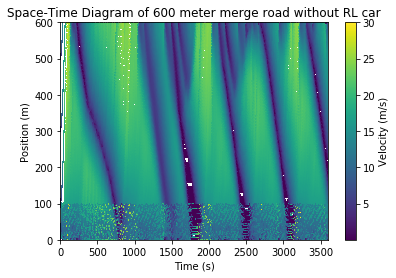

In [66]:
x = np.arange(int(env.env_params.horizon))
y = np.arange(0, int(left_length), step=0.1)
xx, yy = np.meshgrid(x, y)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
title = 'Space-Time Diagram of 600 meter merge road without RL car'
savepath = '../result/' + title.replace(' ', '_') + '.png'
plt.title(title)
plt.pcolormesh(xx, yy, vel_map_list.T)
clb = plt.colorbar()
clb.set_label('Velocity (m/s)')
plt.savefig(savepath)